<a href="https://colab.research.google.com/github/BKV15/AI_Utech/blob/main/Machine%20Learning/Project%201%20-%20Covid%20Vaccination/Covid_Vaccination.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project 1 - Covid Vaccination

<img src = "https://www.coe.int/documents/21202288/62129062/languages-COVID-19_used+by+CoE+main+portal.jpg/b9882ed7-9e7b-caf8-c6e4-9cec0f125baa?t=1585837178000">

## 0 - Preparation

## ` Downloading dataset from kaggle`
* Make sure to upload your kaggle.json first

In [ ]:
!pip install kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download gpreda/covid-world-vaccination-progress -f country_vaccinations.csv

In [ ]:
!unzip country_vaccinations.csv.zip

## ` Importing libraries`

In [112]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.model_selection import train_test_split , cross_validate , GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder , PolynomialFeatures
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
import xgboost as xgb
import warnings

## `Notebook Settings`

In [4]:
sns.set_theme(style='darkgrid')
warnings.filterwarnings("ignore")

## ` Loading dataset`

In [5]:
dataset = pd.read_csv('country_vaccinations.csv')
dataset.sample()

,country,iso_code,date,total_vaccinations,people_vaccinated,people_fully_vaccinated,daily_vaccinations_raw,daily_vaccinations,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,daily_vaccinations_per_million,vaccines,source_name,source_website
31528,Kosovo,OWID_KOS,2021-06-03,NaN,NaN,NaN,NaN,1326.0,NaN,NaN,NaN,744.0,"Oxford/AstraZeneca, Pfizer/BioNTech",Ministry of Health,https://www.facebook.com/Ministria.Shendetesis...


## 1 - Introduction and Data Cleaning

## ` Converting date to datetime format`

In [6]:
dataset['date'] = pd.to_datetime(dataset['date'])

## ` Missing values and unnecessary columns`
Before we can do anything with this dataset, we need to deal with huge number of missing values and drop columns that aren't needed for analysis.

In [7]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65391 entries, 0 to 65390
Data columns (total 15 columns):
 #   Column                               Non-Null Count  Dtype         
---  ------                               --------------  -----         
 0   country                              65391 non-null  object        
 1   iso_code                             65391 non-null  object        
 2   date                                 65391 non-null  datetime64[ns]
 3   total_vaccinations                   34419 non-null  float64       
 4   people_vaccinated                    32942 non-null  float64       
 5   people_fully_vaccinated              30290 non-null  float64       
 6   daily_vaccinations_raw               28002 non-null  float64       
 7   daily_vaccinations                   65014 non-null  float64       
 8   total_vaccinations_per_hundred       34419 non-null  float64       
 9   people_vaccinated_per_hundred        32942 non-null  float64       
 10  people_ful

In [8]:
dataset.isnull().sum()

country                                    0
iso_code                                   0
date                                       0
total_vaccinations                     30972
people_vaccinated                      32449
people_fully_vaccinated                35101
daily_vaccinations_raw                 37389
daily_vaccinations                       377
total_vaccinations_per_hundred         30972
people_vaccinated_per_hundred          32449
people_fully_vaccinated_per_hundred    35101
daily_vaccinations_per_million           377
vaccines                                   0
source_name                                0
source_website                             0
dtype: int64

Since total vaccinations , people vaccinated and people fully vaccinated are cumulative we can't replace null values with mean or zero so we must drop all of them.
<br>
After dropping null values in mentioned columns, aside from `daily vaccinations raw` only `27` null values remains, which can be replace with mean of that column.
<br>
Since `daily vaccinations raw` is closely related to `daily vaccinations`, and there are a lot of null values in it we can easily drop the enitre column without affecting dataset. The same is also true for `iso_code`, `source_name` and `source_website`. They don't add any value to our understanding of this dataset so they can be dropped without any concern.

In [9]:
vaccine_data = dataset.drop(dataset[dataset['total_vaccinations'].isnull()].index)
vaccine_data = vaccine_data.drop(vaccine_data[vaccine_data['people_fully_vaccinated'].isnull()].index)
vaccine_data = vaccine_data.drop(vaccine_data[vaccine_data['people_vaccinated'].isnull()].index)
vaccine_data = vaccine_data.drop(['iso_code' , 'source_name' , 'source_website' , 'daily_vaccinations_raw'] , axis=1)
vaccine_data['daily_vaccinations'].fillna(vaccine_data['daily_vaccinations'].mean() , inplace=True)
vaccine_data['daily_vaccinations_per_million'].fillna(vaccine_data['daily_vaccinations_per_million'].mean() , inplace=True)
vaccine_data['year'] = vaccine_data['date'].dt.year
vaccine_data['month'] = vaccine_data['date'].dt.month
vaccine_data['day'] = vaccine_data['date'].dt.day

In [10]:
vaccine_data.isnull().sum()

country                                0
date                                   0
total_vaccinations                     0
people_vaccinated                      0
people_fully_vaccinated                0
daily_vaccinations                     0
total_vaccinations_per_hundred         0
people_vaccinated_per_hundred          0
people_fully_vaccinated_per_hundred    0
daily_vaccinations_per_million         0
vaccines                               0
year                                   0
month                                  0
day                                    0
dtype: int64

Now we check for making sure no country was dropped in the process of dealing with null values.

In [11]:
print('Number of coutries before dealing of null values : ' , len(dataset.country.unique()))
print('Number of coutries after dealing of null values : ' , len(vaccine_data.country.unique()))

Number of coutries before dealing of null values :  223
Number of coutries after dealing of null values :  223


## 2 - EDA and Visualization

In this step we try to understand dataset better by visualizing different aspects of it.
<br>
The main goal is to study the top 10 country leading in different categories of dataset and comparing them to Iran.

In [12]:
features = ['total_vaccinations','total_vaccinations_per_hundred','daily_vaccinations','daily_vaccinations_per_million',
'people_vaccinated','people_vaccinated_per_hundred','people_fully_vaccinated', 'people_fully_vaccinated_per_hundred']

Comparing Iran vaccinations data to maximum of top 10 countries in dataset show some predictable result :
* ` Being one of the most populous contries in the world, it make sense to see iran total vaccinations and total vaccinated people very close to top 10 countries`
* ` Still comparing to countries with similar population, Iran hasn't done really well simply average`
* ` Interpreting comparison between Iran and the mean values of all the other countries is difficult due to high variation around population`

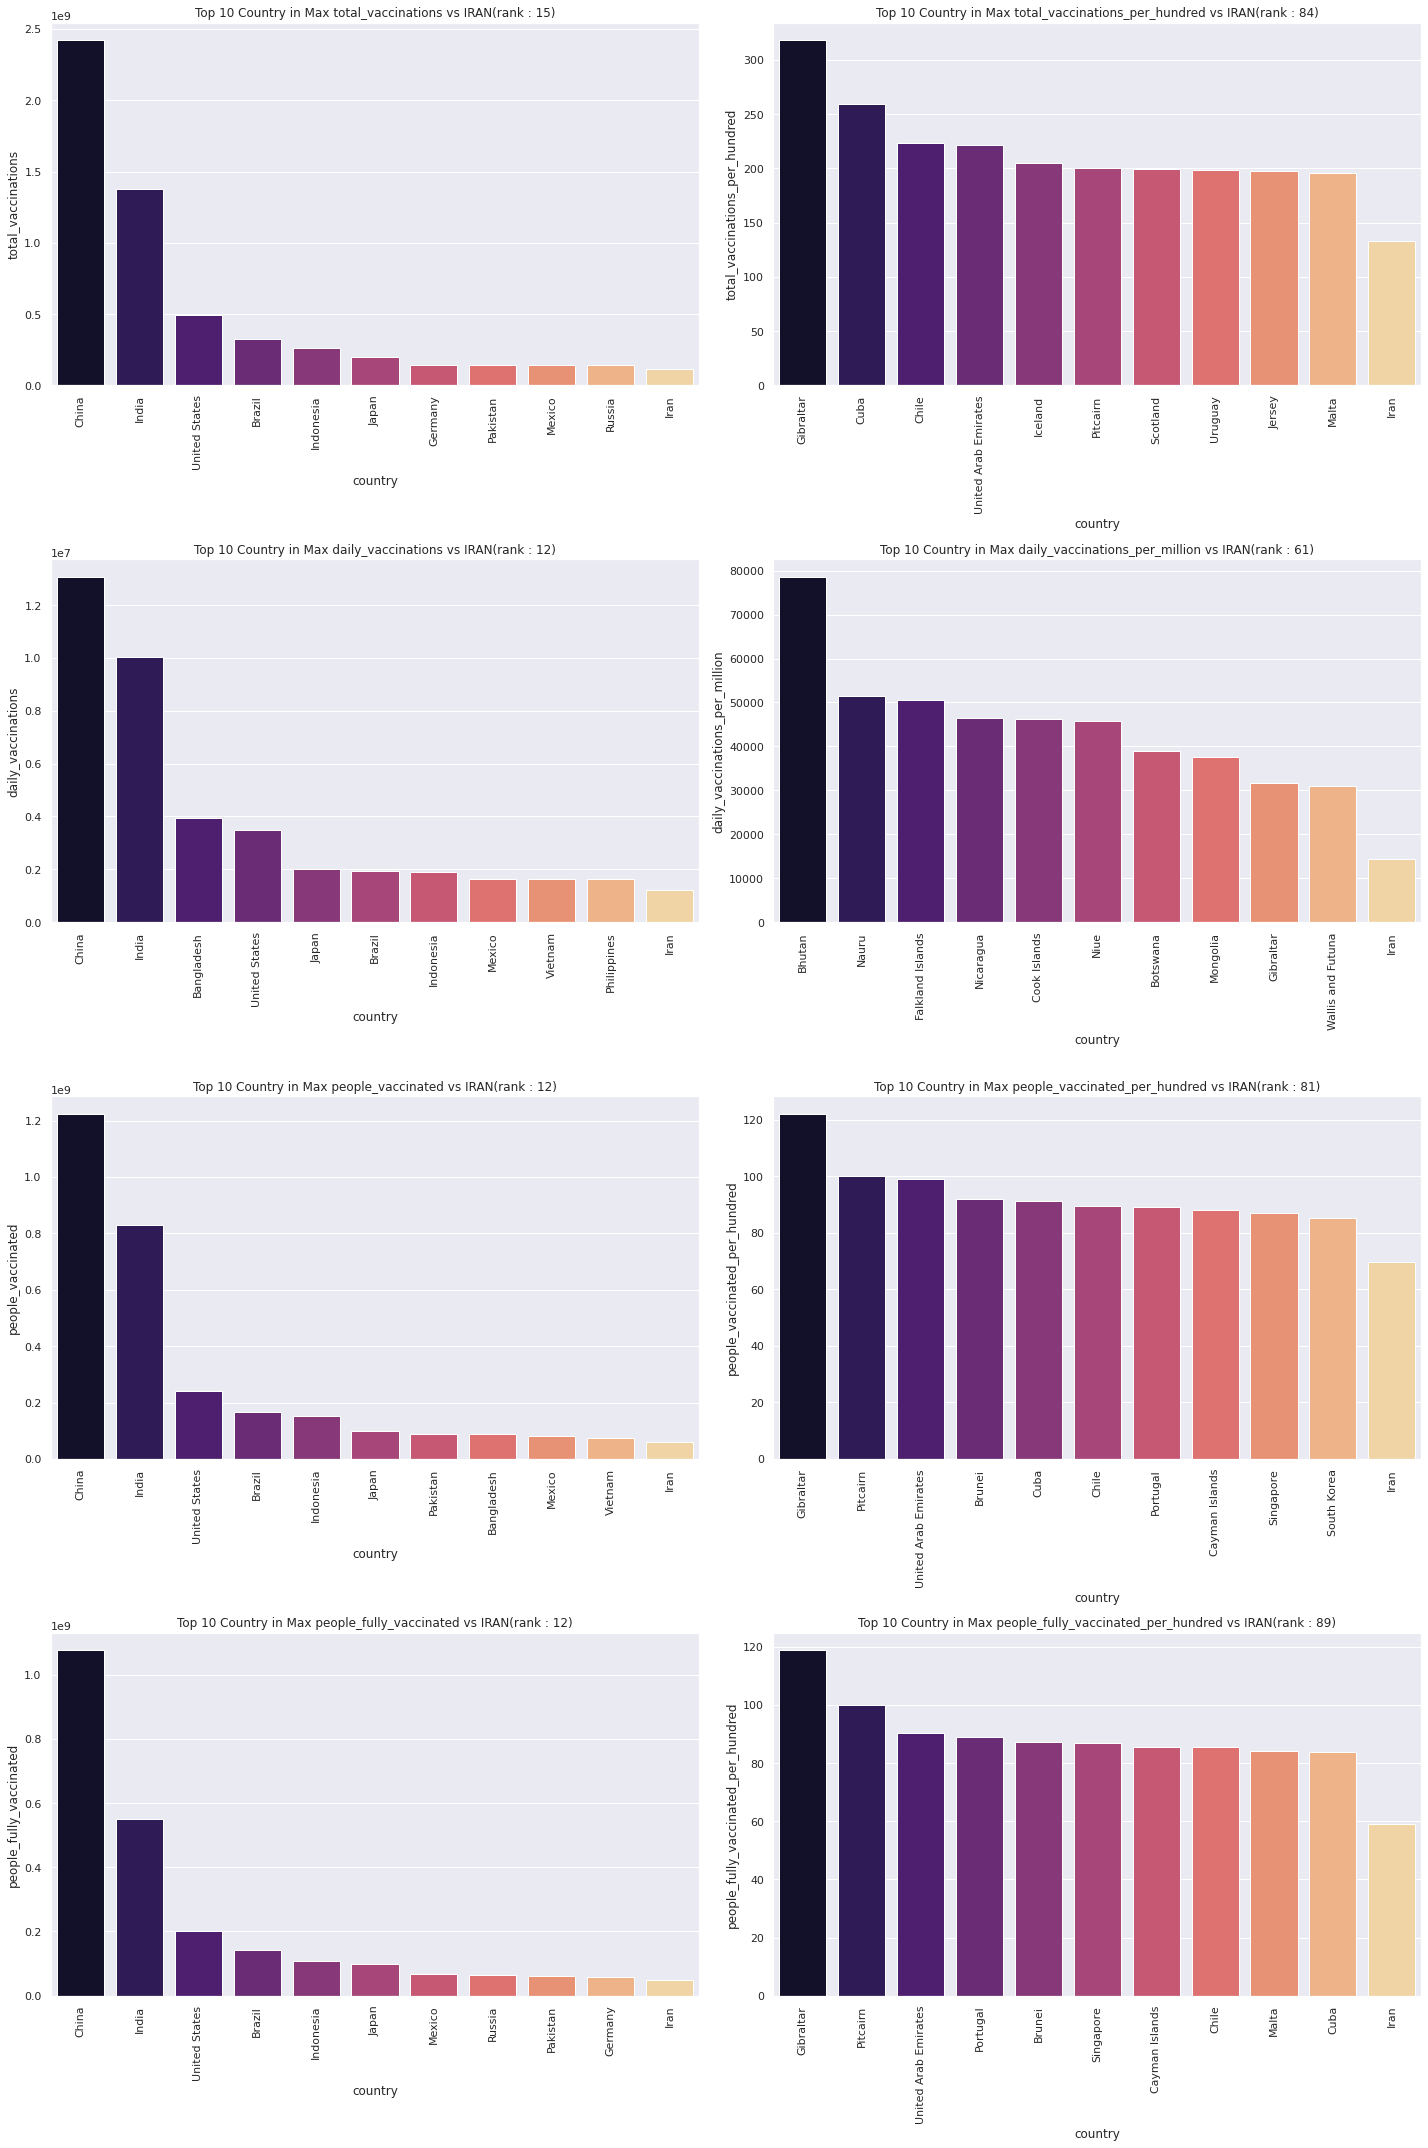

In [13]:
fig , ax = plt.subplots(4 , 2 , figsize=(20,30))

country_vaccine = vaccine_data.groupby(["country"])[features].max().reset_index()
iran = country_vaccine[country_vaccine['country'] == 'Iran']

counter = 0

for i in range(4):
    for j in range(2):
        iran_rank = country_vaccine.sort_values(features[counter] , ascending=False).reset_index()
        iran_rank = iran_rank[iran_rank['country'] == 'Iran'].index
        country = country_vaccine.sort_values(features[counter] , ascending=False)[0:10]
        country = pd.concat([country , iran])
        sns.barplot(data=country , x='country' , y=features[counter] , palette='magma' , ax=ax[i,j])
        ax[i,j].set(title=f'Top 10 Country in Max {features[counter]} vs IRAN(rank : {iran_rank[0]})')
        ax[i,j].set_xticklabels(ax[i,j].get_xticklabels(),rotation=90)
        counter += 1

fig.tight_layout()
plt.show()

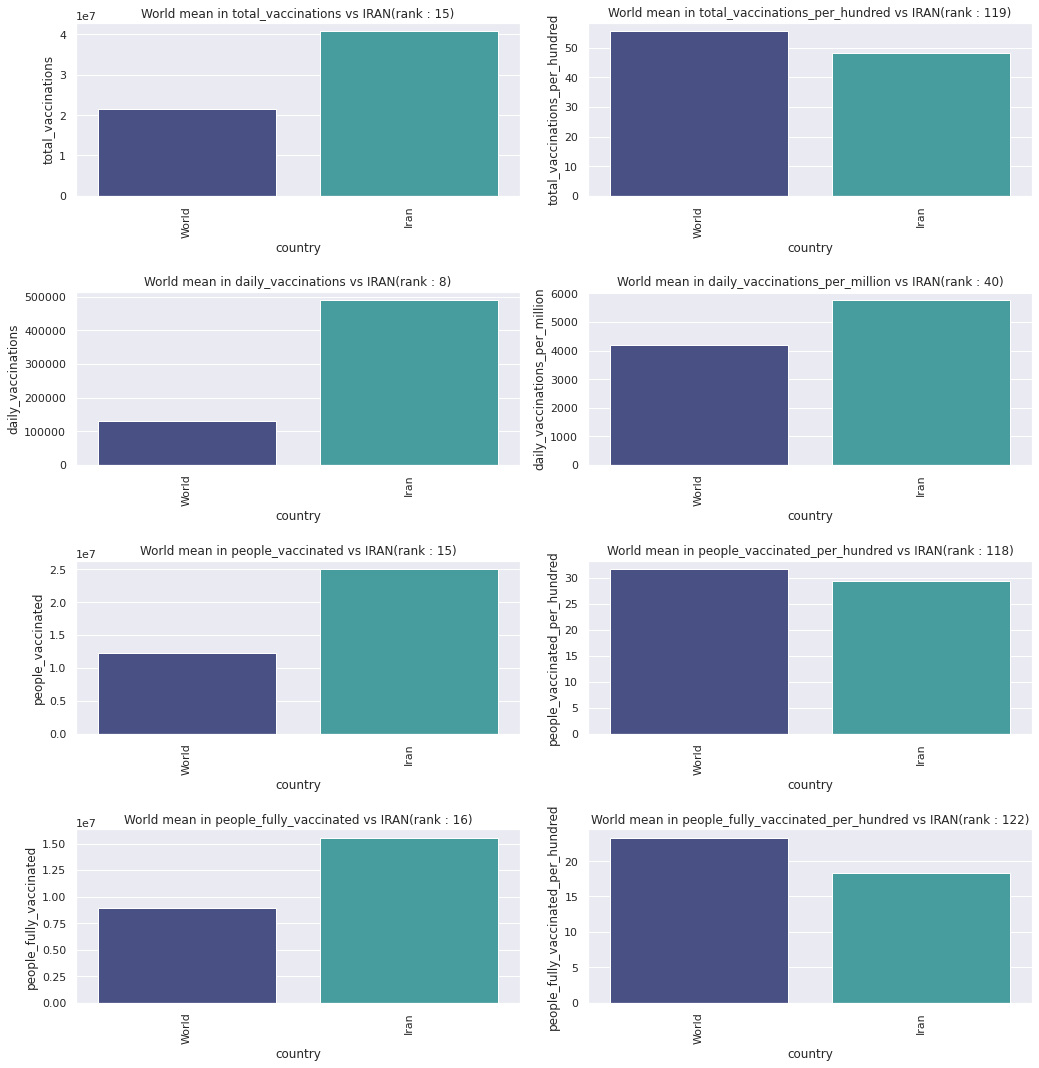

In [14]:
fig , ax = plt.subplots(4 , 2 , figsize=(15 , 15))

country_vaccine_mean = vaccine_data.groupby(["country"])[features].mean().reset_index()
iran = country_vaccine_mean[country_vaccine['country'] == 'Iran']

counter = 0

for i in range(4):
    for j in range(2):

        iran_rank = country_vaccine_mean.sort_values(features[counter] , ascending=False).reset_index()
        iran_rank = iran_rank[iran_rank['country'] == 'Iran'].index

        world = country_vaccine_mean[features[counter]].mean()
        world = pd.DataFrame({'country' : ['World'] , f'{features[counter]}' : [world]})
        world = pd.concat([world , iran[['country',features[counter]]]])

        sns.barplot(data=world , x='country' , y=features[counter] , palette='mako' , ax=ax[i,j])
        ax[i,j].set(title=f'World mean in {features[counter]} vs IRAN(rank : {iran_rank[0]})')
        ax[i,j].set_xticklabels(ax[i,j].get_xticklabels(),rotation=90)
        counter += 1

fig.tight_layout()
plt.show()

Comparing Iran `people vaccinated_per_hundred` and `daily vaccinations` as time progress to rest of the world :
* `Rate of vaccination in Iran increases as times go and either get close or overtake most other countries, which is a good things`
* ` In most cases Iran daily vaccination is lower at the start of vaccination process and usually overtake other countries way past the starting process of vaccination. This shows that Iran started vaccination process much later than other countries`
* ` There is huge drop in daily vaccination in Iran after 11/2021 which shows that most people got two does of vaccine and are waiting for their third does`

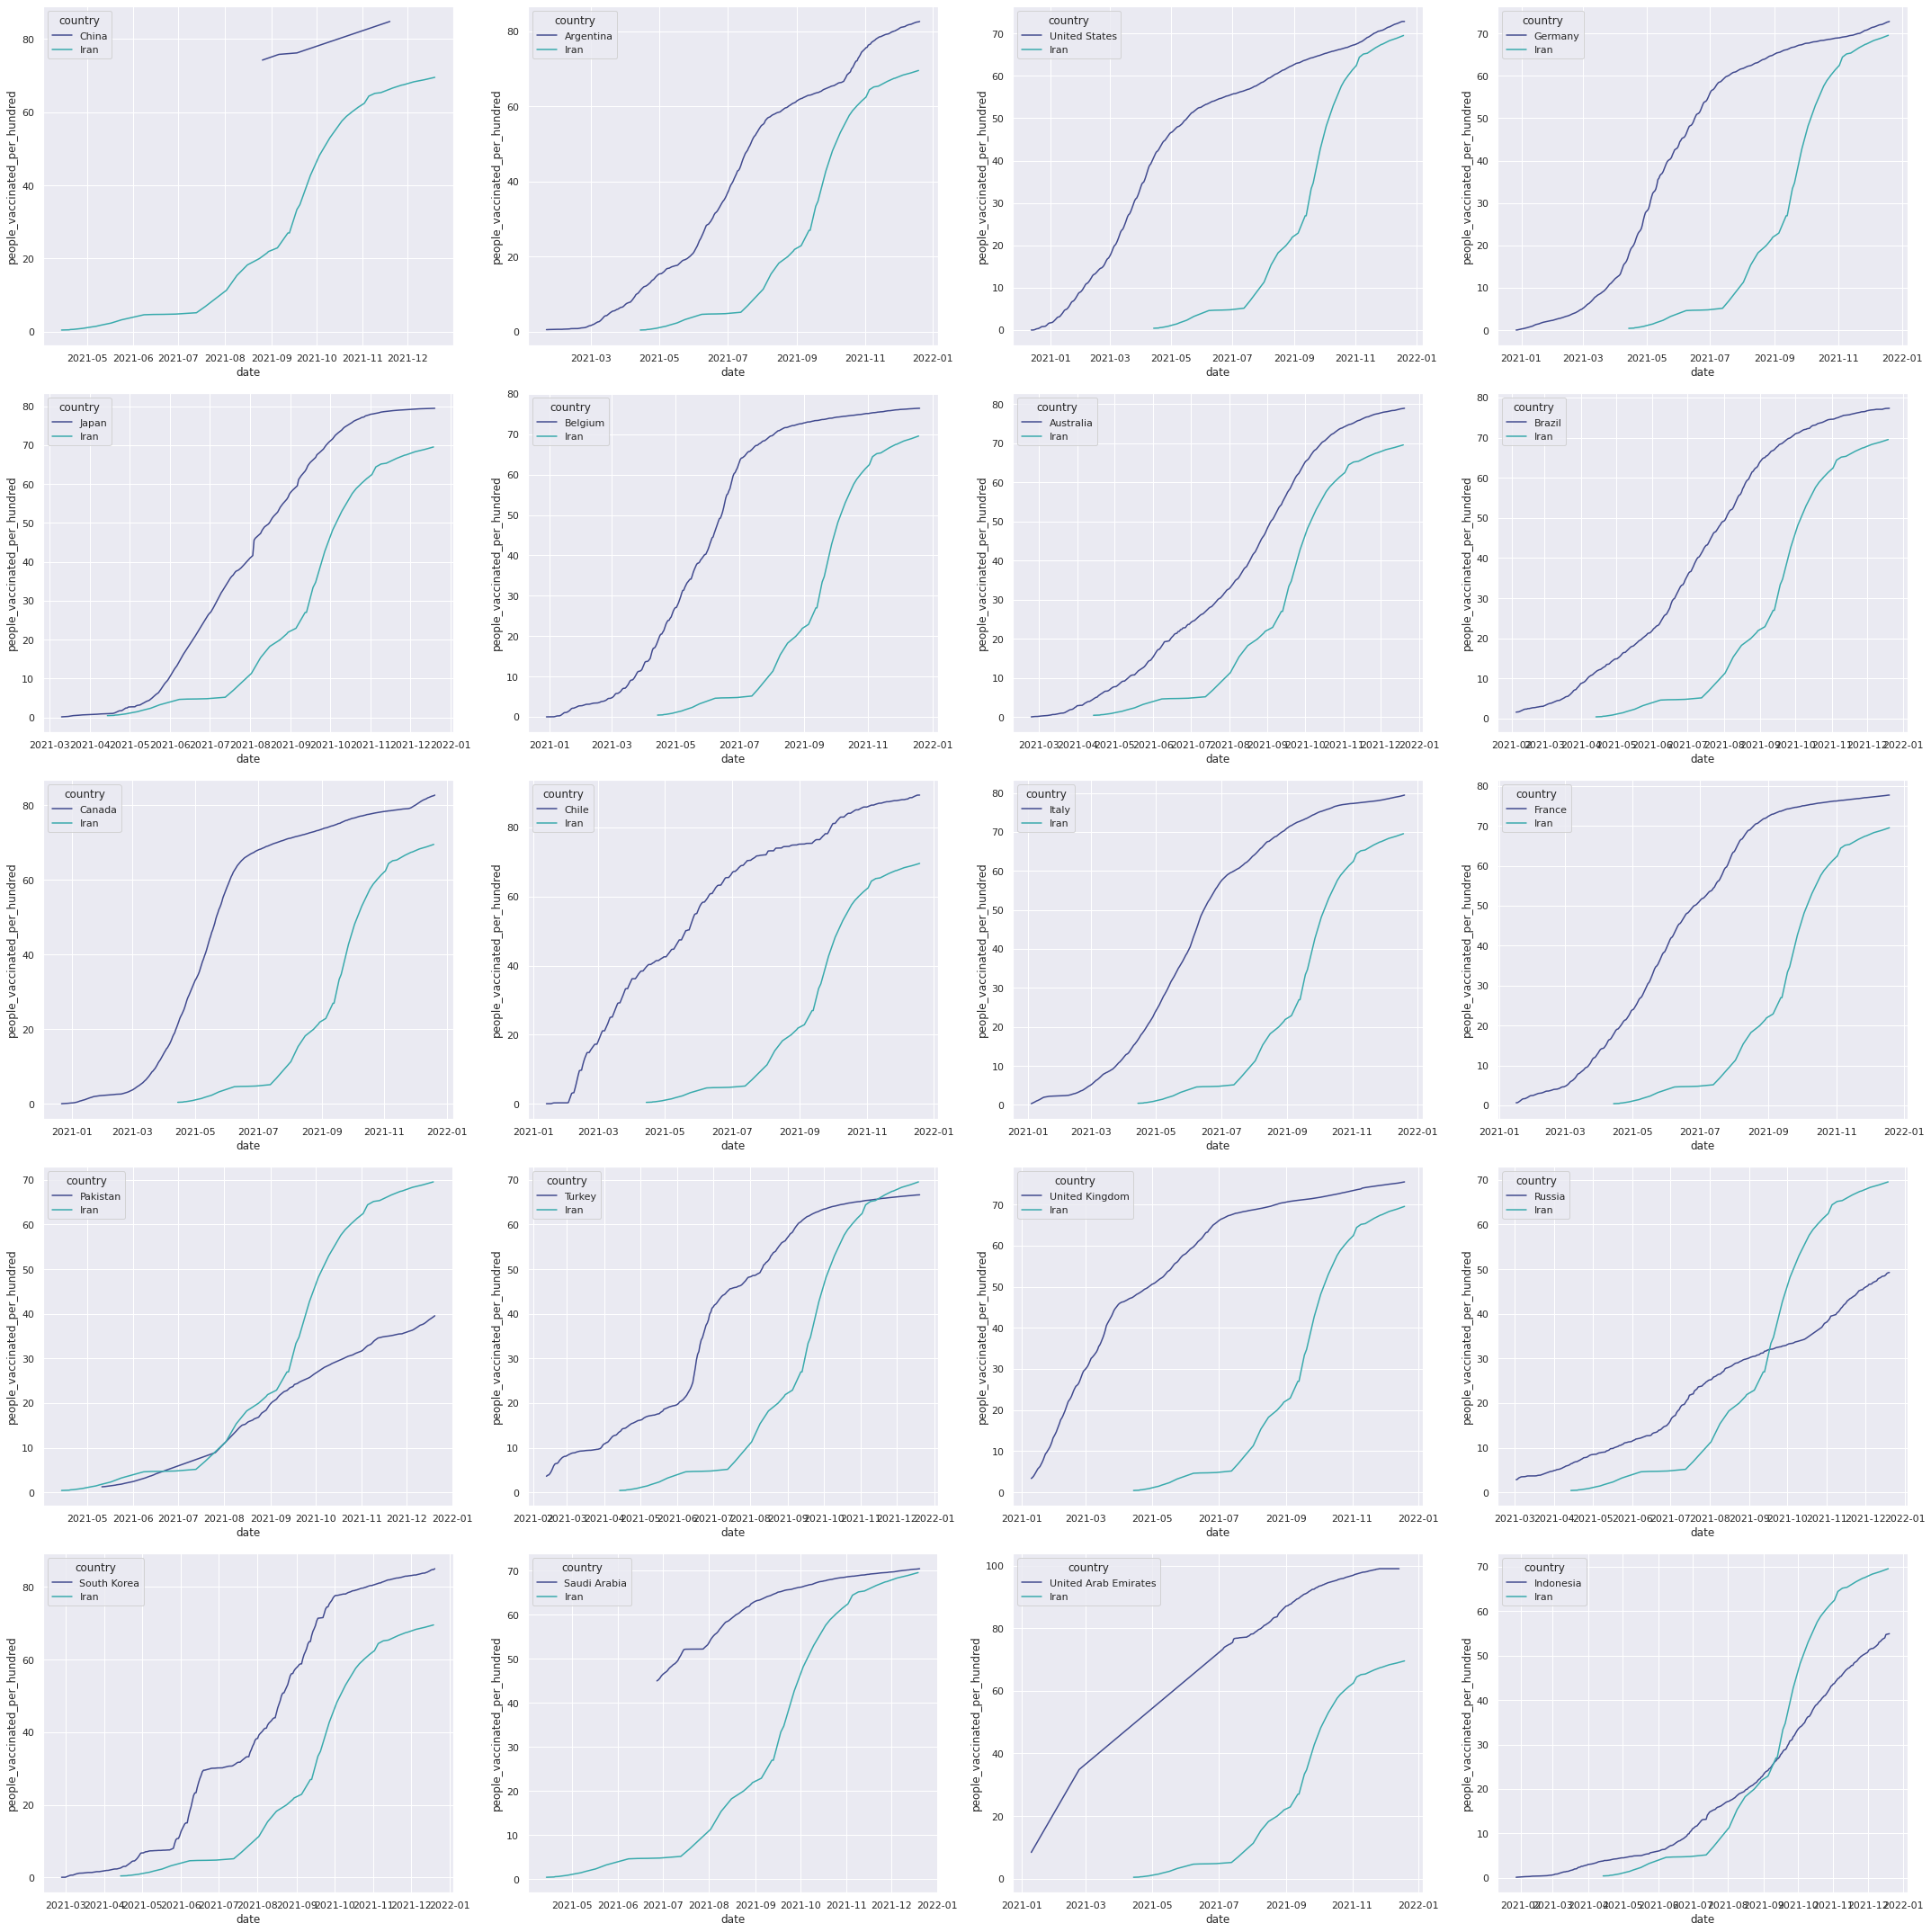

In [15]:
list_countries = ['China' , 'Argentina' , 'United States' , 'Germany' , 'Japan' , 'Belgium' , 'Australia' , 'Brazil' , 'Canada',
                  'Chile' , 'Italy' , 'France' , 'Pakistan' , 'Turkey' , 'United Kingdom' , 'Russia' , 'South Korea' , 'Saudi Arabia',
                  'United Arab Emirates' , 'Indonesia']

fig , ax = plt.subplots(5,4,figsize=(30,30))
counter = 0

for i in range(5):
    for j in range(4):

        countries = pd.DataFrame()
        countries = pd.concat([countries , vaccine_data[vaccine_data['country'] == list_countries[counter]]])
        countries = pd.concat([countries , vaccine_data[vaccine_data['country'] == 'Iran']])

        sns.lineplot(data=countries , x='date' , y='people_vaccinated_per_hundred', hue='country' , palette='mako' , ax=ax[i,j])

        counter += 1

fig.tight_layout()
plt.show()

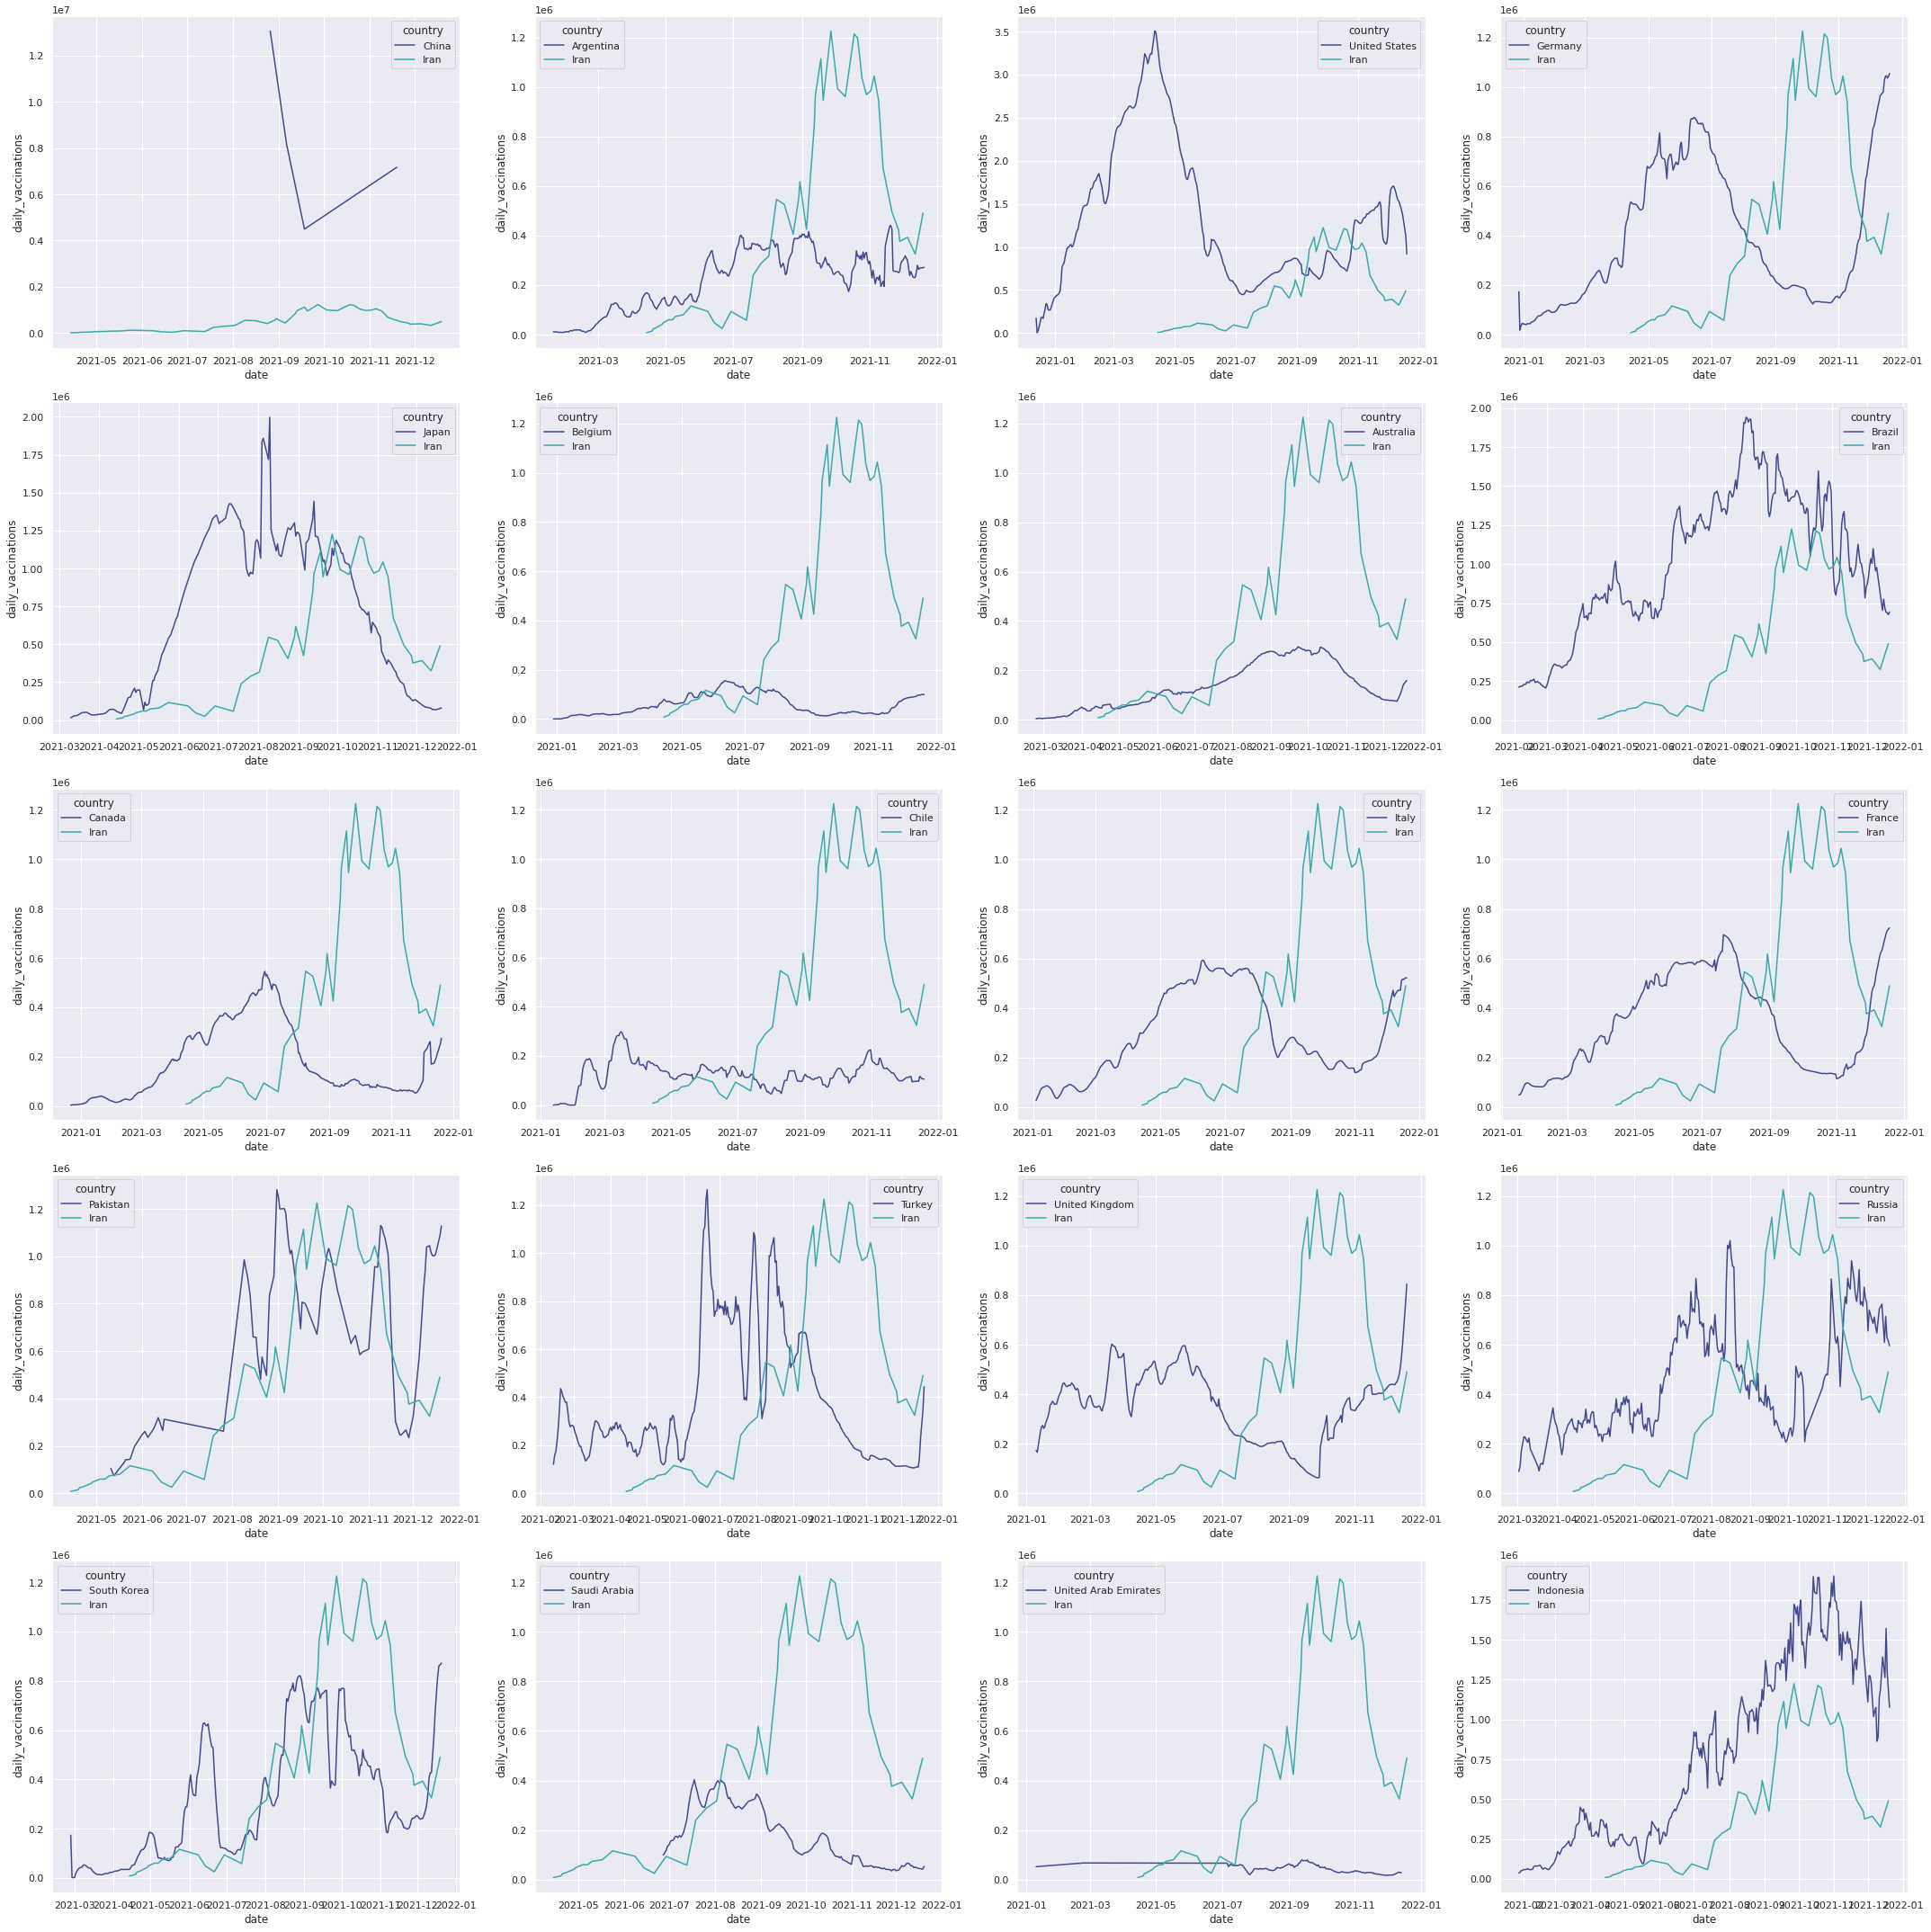

In [16]:
list_countries = ['China' , 'Argentina' , 'United States' , 'Germany' , 'Japan' , 'Belgium' , 'Australia' , 'Brazil' , 'Canada',
                  'Chile' , 'Italy' , 'France' , 'Pakistan' , 'Turkey' , 'United Kingdom' , 'Russia' , 'South Korea' , 'Saudi Arabia',
                  'United Arab Emirates' , 'Indonesia']

fig , ax = plt.subplots(5,4,figsize=(30,30))
counter = 0

for i in range(5):
    for j in range(4):

        countries = pd.DataFrame()
        countries = pd.concat([countries , vaccine_data[vaccine_data['country'] == list_countries[counter]]])
        countries = pd.concat([countries , vaccine_data[vaccine_data['country'] == 'Iran']])

        sns.lineplot(data=countries , x='date' , y='daily_vaccinations', hue='country' , palette='mako' , ax=ax[i,j])

        counter += 1

fig.tight_layout()
plt.show()

Comparing different vaccination schemes used in different countries :
* `Chinese vaccines have the most total vaccination in all of vaccine schemes unsurprisingly`
* ` The most popular vaccines used across the world are Sinopharm, J&J, Pfizer, AstraZeneca and Moderna` 

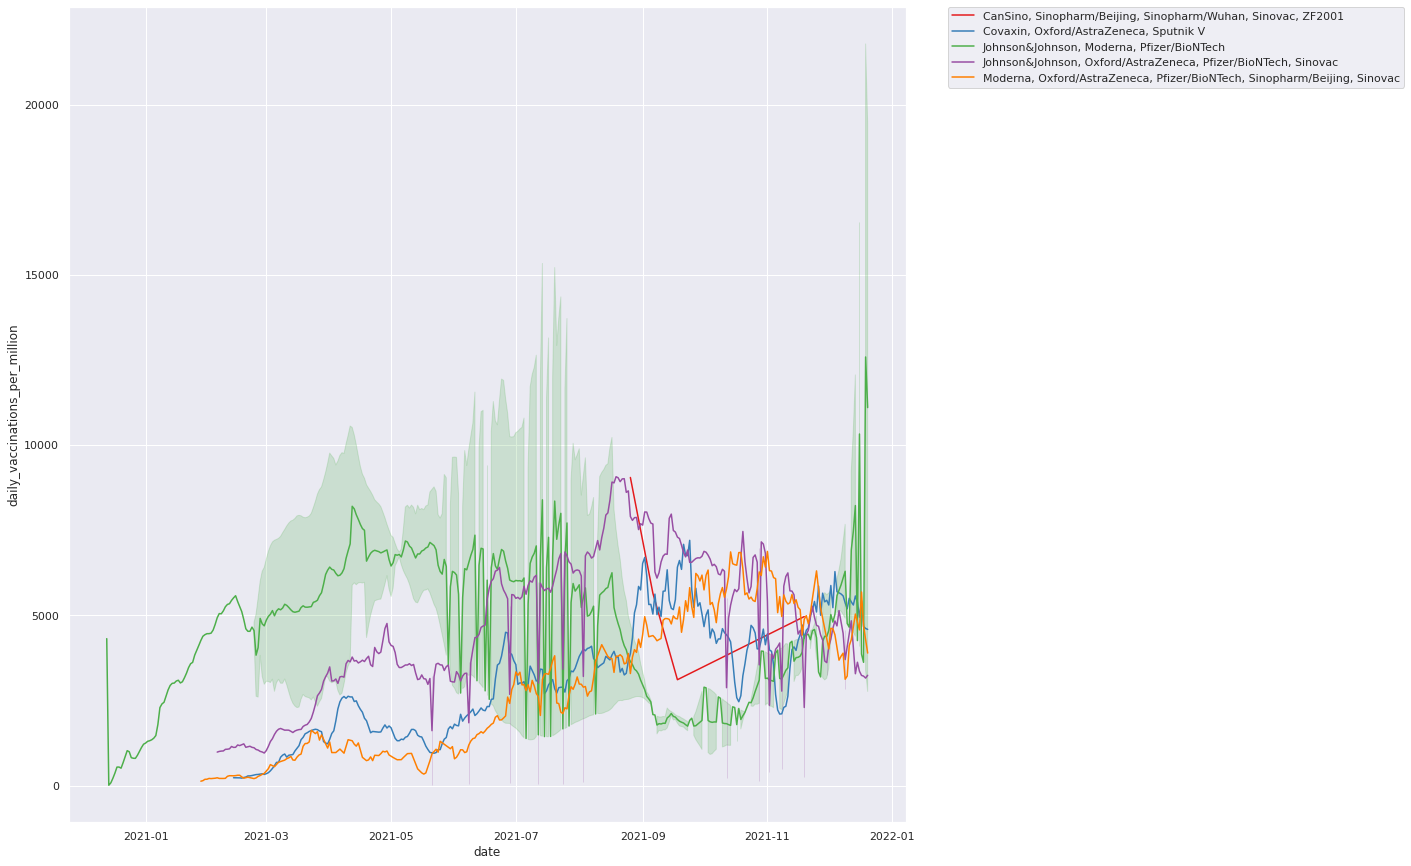

In [17]:
plt.figure(figsize=(15,15))

vaccines_data = vaccine_data.groupby(['vaccines'])[features].max().reset_index()
list_vaccines = list(vaccines_data.sort_values('total_vaccinations',ascending=False)[:5].vaccines)

vaccine = pd.DataFrame()

for index in range(len(list_vaccines)):
    vaccine = pd.concat([vaccine , vaccine_data[vaccine_data['vaccines'] == list_vaccines[index]]])

sns.lineplot(data=vaccine , x='date' , y='daily_vaccinations_per_million' , hue='vaccines' , palette='Set1')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

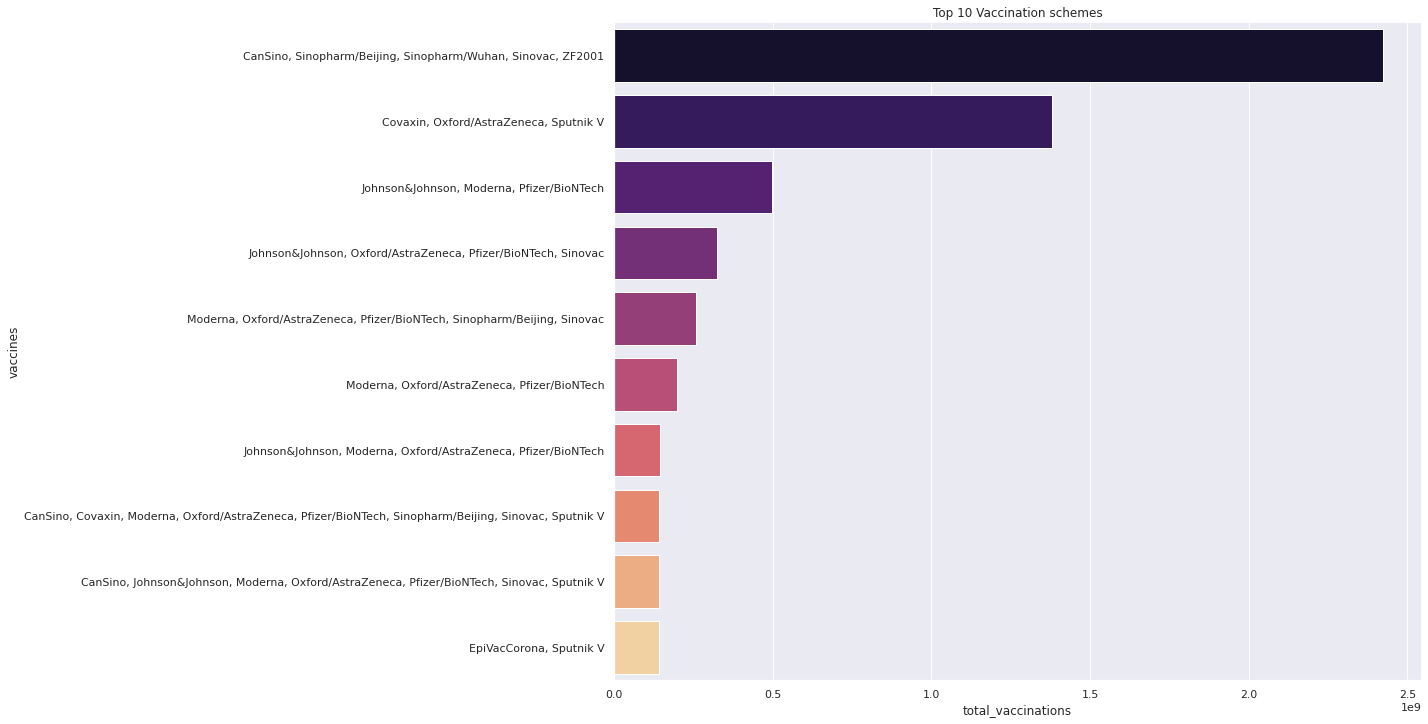

In [18]:
vaccines = vaccine_data.groupby('vaccines')['total_vaccinations', 
                                       'total_vaccinations_per_hundred',
                                       'daily_vaccinations',
                                       'daily_vaccinations_per_million'].max().reset_index()
vaccines = vaccines.sort_values('total_vaccinations' , ascending=False)[0:10]
fig = sns.catplot(data=vaccines , x='total_vaccinations' , y='vaccines' , kind='bar', palette='magma' , height=10 , aspect=2)
fig.set(title='Top 10 Vaccination schemes')
plt.show()

## Machine Learning and Forecasting

Creating a ml model for this dataset is harder than it first appears. The main and first problems is what is a good target ? What do you want to predict in this dataset?
<br>
The second problem is since this is a time series problem aside from date, country and vaccination schemes, other features are problematic. Why ? Because we don't have those data for the future and also they are dependent on our target.
<br>
For this notebook I am going to chose `daily vaccinations` as my target. The final goal is To forecast `daily vaccination` for `Iran` in 2022. Although this prediction probably isn't very accurate because only one factor is taken into consideration.

## ` Data Preprocessing`
Selecting our features and target

In [19]:
X = vaccine_data.iloc[: , [0,10,11,12,13]]
X['country'] = X['country'].astype('category')
X['vaccines'] = X['vaccines'].astype('category')
X = X.values
y = vaccine_data.iloc[: , [5]].values

OneHotEncoding country and vaccines

In [20]:
ct = ColumnTransformer(transformers=[('encoder' , OneHotEncoder(sparse=False) , [0,1])] , remainder='passthrough')
X = ct.fit_transform(X)

## ` Splitting our dataset into train and test`

In [21]:
X_train , X_test , y_train , y_test = train_test_split(X , y , test_size=0.2)
print(f'X_train : {X_train.shape}')
print(f'X_test : {X_test.shape}')
print(f'y_train : {y_train.shape}')
print(f'y_test : {y_test.shape}')

X_train : (23475, 303)
X_test : (5869, 303)
y_train : (23475, 1)
y_test : (5869, 1)


## ` Forecasting dataset for Iran`

In [100]:
forecast_iran = pd.DataFrame(pd.date_range(start='01/01/2022' , periods=365) , columns=['date'])
forecast_iran['country'] = 'Iran'
forecast_iran['vaccines'] = vaccine_data[vaccine_data['country'] == 'Iran'].vaccines.unique()[0]
forecast_iran['year'] = forecast_iran['date'].dt.year
forecast_iran['month'] = forecast_iran['date'].dt.month
forecast_iran['day'] = forecast_iran['date'].dt.day

X_iran = forecast_iran.iloc[: , 1:].values
X_iran = ct.transform(X_iran)

## ` Choosing the best model`

Now that our data is ready for training we need to choose the best model. For this purpose we use corss_validation on different model and evaluate those models based on `MAE`, `MSE`, `RMSE` and `R2-Score`. Model that have the best score will be choosed for further training.

### ` Scores`

In [22]:
scoring = ['neg_mean_absolute_error' , 'neg_mean_squared_error' , 'neg_root_mean_squared_error' , 'r2']

### `Models`

In [23]:
regressors = []
names = ['mlr' , 'knn' , 'dtr' , 'rfr' , 'xgbr' , 'svr']

## Multiple Linear Regressor
mlr = LinearRegression()
regressors.append(mlr)

## K Nearest Neighbor Regressor
knn = KNeighborsRegressor()
regressors.append(knn)

## Decision Tree Regressor
dtr = DecisionTreeRegressor()
regressors.append(dtr)

## Random Forest Regressor
rfr = RandomForestRegressor()
regressors.append(rfr)

## XGBoost Regressor
xgbr = xgb.XGBRegressor(n_jobs=-1)
regressors.append(xgbr)

## Support Vector Regressor
svr = SVR()      
regressors.append(svr)


### ` Cross validation and visualizing result`

Taking a look at our metrics for each model `Decision Tree` and `Random Forest` are the best model for this problem.

In [25]:
## Warning : This cell takes forever to run

model_evaluation = []

for model , name in zip(regressors , names):
    
    temp_list = []
    temp_list.append(name)

    scores = cross_validate(
        estimator = model,
        X = X_train,
        y = y_train,
        cv = 10,
        scoring = scoring
    )

    temp_list.append(scores['test_neg_mean_absolute_error'].mean() * -1)
    temp_list.append(scores['test_neg_mean_squared_error'].mean() * -1)
    temp_list.append(scores['test_neg_root_mean_squared_error'].mean() * -1)
    temp_list.append(scores['test_r2'].mean())

    model_evaluation.append(temp_list)

[09:19:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:19:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:19:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:19:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:19:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:19:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:20:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:20:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

In [26]:
model_evaluation = pd.DataFrame(model_evaluation , columns=['Model' , 'MAE' , 'MSE' , 'RMSE' , 'R2'])

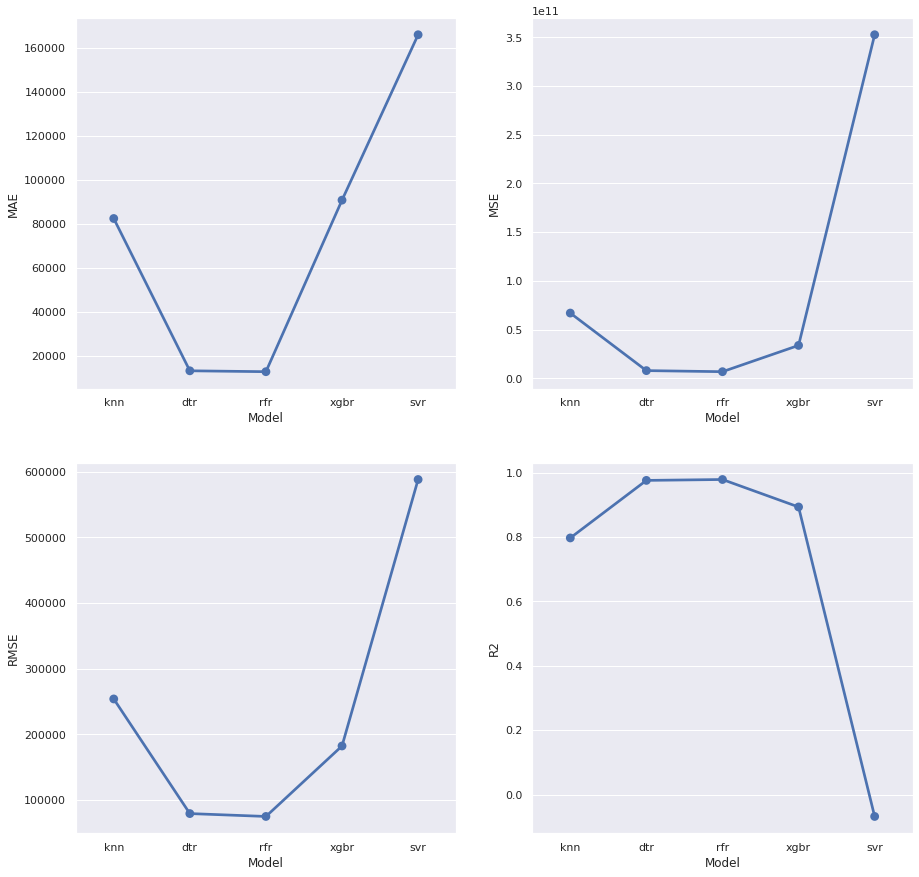

In [27]:
fig , ax = plt.subplots(2,2,figsize=(15,15))
sns.pointplot(data=model_evaluation[1:] , x='Model' , y='MAE' , ax=ax[0,0])
sns.pointplot(data=model_evaluation[1:] , x='Model' , y='MSE' , ax=ax[0,1])
sns.pointplot(data=model_evaluation[1:] , x='Model' , y='RMSE' , ax=ax[1,0])
sns.pointplot(data=model_evaluation[1:] , x='Model' , y='R2' , ax=ax[1,1])

## ` Decision Tree Regression`

In [107]:
dtr = DecisionTreeRegressor()
dtr.fit(X_train , y_train)
y_pred_dtr = dtr.predict(X_test)

### `Evaluation`

In [108]:
df = pd.concat([pd.DataFrame(X_test) , pd.Series(np.squeeze(y_test) , name='actual')] , axis=1)
df = pd.concat([df , pd.Series(y_pred_dtr , name='prediction')] , axis=1)
df['date'] = df[[300,301,302]].apply(lambda row : '-'.join(row.values.astype(str)) , axis=1)
df['date'] = pd.to_datetime(df['date'])

Text(0, 0.5, 'Actual vs Prediction')

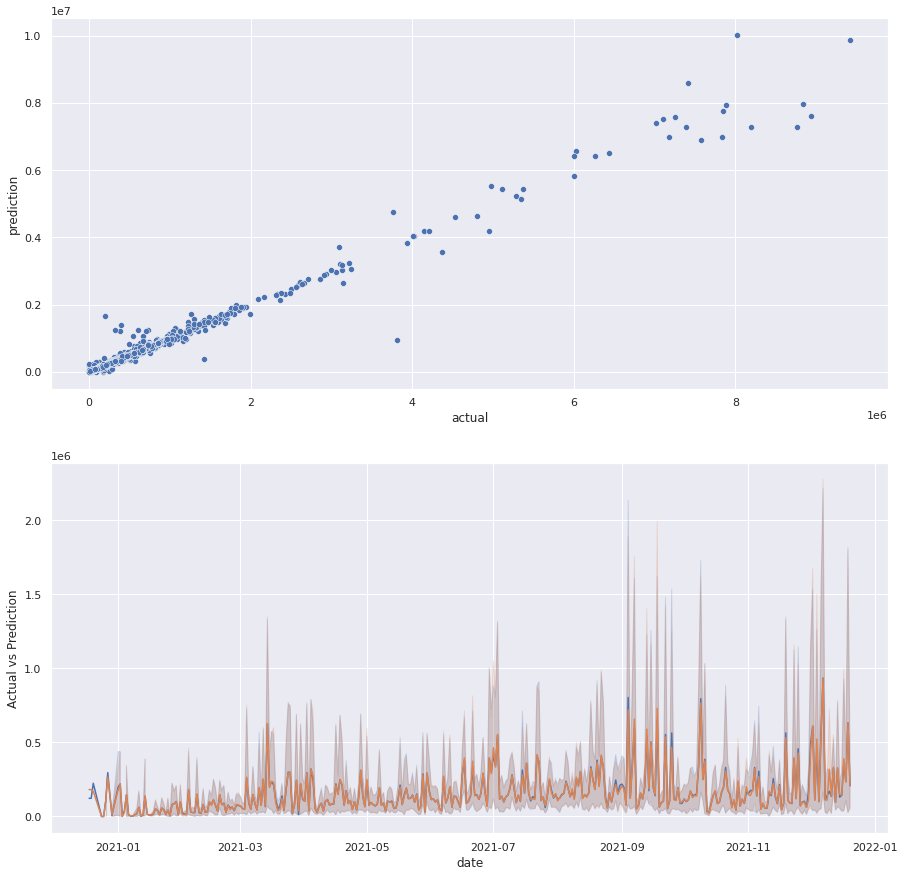

In [109]:
fig , ax = plt.subplots(2 , figsize=(15,15))
sns.scatterplot(data=df , x='actual' , y='prediction' , ax=ax[0])
sns.lineplot(data=df , x='date' , y='prediction' , ax=ax[1])
sns.lineplot(data=df , x='date' , y='actual' , ax=ax[1])
ax[1].set_ylabel('Actual vs Prediction')

### ` Metrics`

In [113]:
print(f'MAE : {metrics.mean_absolute_error(y_test , y_pred_dtr)}')
print(f'MSE : {metrics.mean_squared_error(y_test , y_pred_dtr)}')
print(f'RMSE : {np.sqrt(metrics.mean_squared_error(y_test , y_pred_dtr))}')
print(f'R^2 : {metrics.r2_score(y_test , y_pred_dtr)}')

MAE : 13062.380567600976
MSE : 6093161025.323244
RMSE : 78058.70243171637
R^2 : 0.9821184757750304


## ` Random Forest Regression`

In [102]:
rfr = RandomForestRegressor()

params = [{'n_estimators' : [100,200,300]}]

grid_search = GridSearchCV(estimator=rfr , param_grid=params , scoring='r2' , cv=5 , n_jobs=-1)
grid_search.fit(X_train , y_train)

print(f'Best_score : {grid_search.best_score_}')
print(f'Best_parameter : {grid_search.best_params_}')

Best_score : 0.9795289759621566
Best_parameter : {'n_estimators': 300}


### ` Evaluation`

In [110]:
y_pred_rfr = grid_search.best_estimator_.predict(X_test)
df = pd.concat([pd.DataFrame(X_test) , pd.Series(np.squeeze(y_test) , name='actual')] , axis=1)
df = pd.concat([df , pd.Series(y_pred_rfr , name='prediction')] , axis=1)
df['date'] = df[[300,301,302]].apply(lambda row : '-'.join(row.values.astype(str)) , axis=1)
df['date'] = pd.to_datetime(df['date'])

Text(0, 0.5, 'Actual vs Prediction')

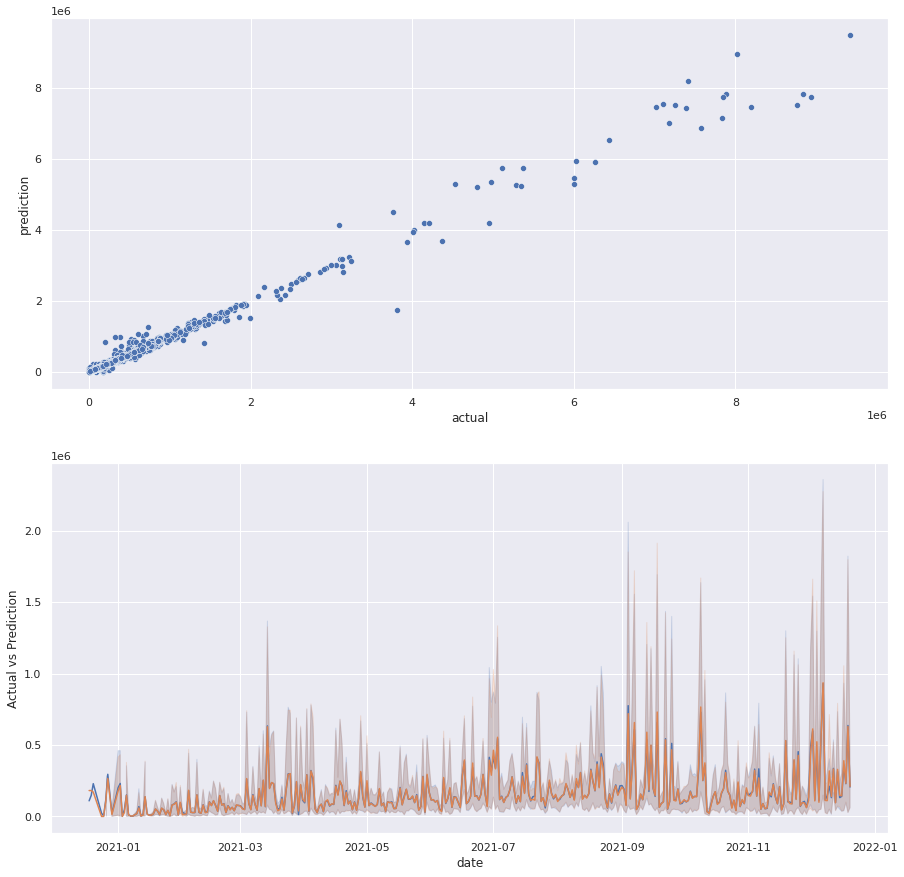

In [111]:
fig , ax = plt.subplots(2 , figsize=(15,15))
sns.scatterplot(data=df , x='actual' , y='prediction' , ax=ax[0])
sns.lineplot(data=df , x='date' , y='prediction' , ax=ax[1])
sns.lineplot(data=df , x='date' , y='actual' , ax=ax[1])
ax[1].set_ylabel('Actual vs Prediction')

### ` Metrics`

In [114]:
print(f'MAE : {metrics.mean_absolute_error(y_test , y_pred_rfr)}')
print(f'MSE : {metrics.mean_squared_error(y_test , y_pred_rfr)}')
print(f'RMSE : {np.sqrt(metrics.mean_squared_error(y_test , y_pred_rfr))}')
print(f'R^2 : {metrics.r2_score(y_test , y_pred_rfr)}')

MAE : 12142.979929486366
MSE : 3974550210.008993
RMSE : 63044.033897023066
R^2 : 0.9883359367053879


## ` Iran Forecasting`

Based on this forecasting Iran daily vaccination drops at the start of 2022 but speed on again on the last three month of 2022 which could foreshodw another peak of covid hospitalization.

In [117]:
y_iran_dtr = dtr.predict(X_iran)
y_iran_rfr = grid_search.best_estimator_.predict(X_iran)
forecast_iran = pd.concat([forecast_iran , pd.Series(y_iran_dtr , name='prediction_decision_tree')] , axis=1)
forecast_iran = pd.concat([forecast_iran , pd.Series(y_iran_rfr , name='prediction_random_forest')] , axis=1)

Text(0, 0.5, 'Decision Tree vs Random Forest')

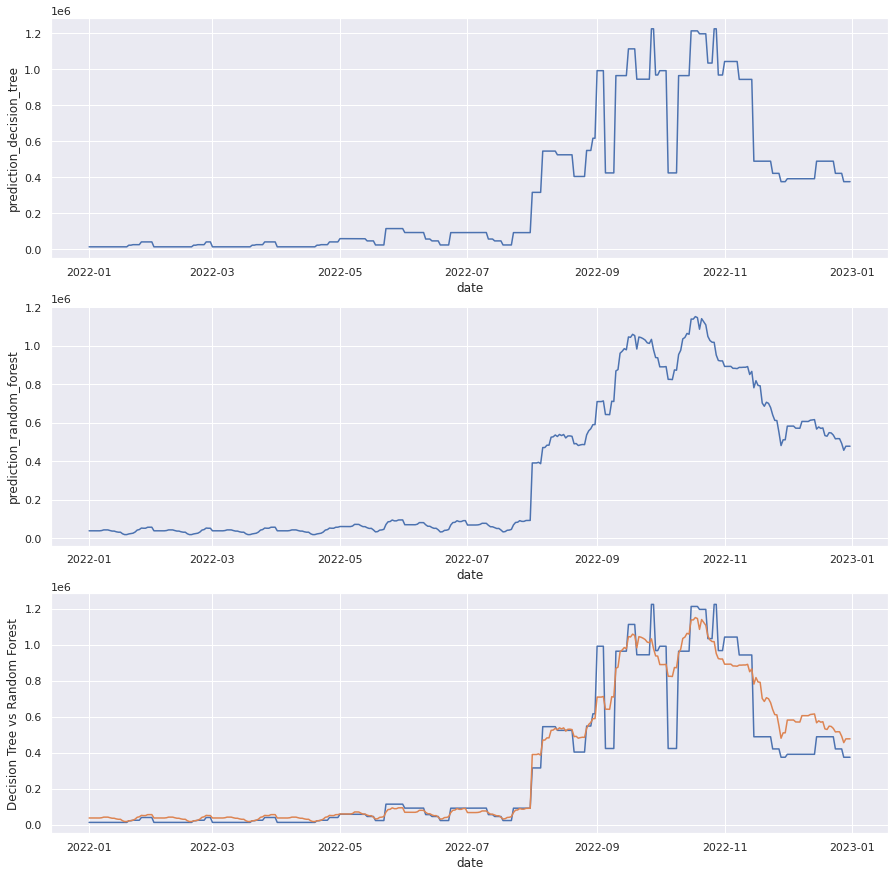

In [125]:
fig , ax = plt.subplots(3 , figsize=(15,15))
sns.lineplot(data=forecast_iran , x='date' , y='prediction_decision_tree' , ax=ax[0])
sns.lineplot(data=forecast_iran , x='date' , y='prediction_random_forest' , ax=ax[1])
sns.lineplot(data=forecast_iran , x='date' , y='prediction_decision_tree' , ax=ax[2])
sns.lineplot(data=forecast_iran , x='date' , y='prediction_random_forest' , ax=ax[2])
ax[2].set_ylabel('Decision Tree vs Random Forest')

## Thank you for taking the time to read this notebook. I greatly appreciate it.